In [16]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 10)
        self.mean = nn.Linear(50, 3)
        self.sigma = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #x = self.fc2(x)
        mean = self.mean(x)
        sigma = self.sigma(x)
        return mean, sigma
        mean = mean / (1. + mean.norm(dim=1, keepdim=True)**2).sqrt()
        sigma = sigma / (1. + sigma.norm(dim=1, keepdim=True)**2).sqrt()
        return mean , sigma

In [64]:
device = torch.device("cuda")

In [65]:
kwargs = {'num_workers': 1, 'pin_memory': True}

In [66]:
b_size = 8192
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=b_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=b_size, shuffle=True, **kwargs)

In [67]:
import numpy as np
def laplacian_clusters(nodes_predictions, true_labels):
    nodes_medians, nodes_log_b = nodes_predictions

    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        labeled_medians = nodes_medians[true_labels==label]
        labeled_log_b = nodes_log_b[true_labels==label]
        median = labeled_medians.median(dim=0)[0]
        b = torch.abs(labeled_medians - median).mean(dim=0) + (labeled_log_b.exp() * torch.exp(-torch.abs(labeled_medians - median) / labeled_log_b.exp())).mean(dim=0)
        clusters[label] = {
            'median': median, # 
            'b': b
        }
    
    return clusters


def gaussian_clusters(nodes_predictions, true_labels):
    nodes_means, nodes_log_std = nodes_predictions
    
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        labeled_means = nodes_means[true_labels==label]
        labeled_log_std = nodes_log_std[true_labels==label]
        
        mean = labeled_means.mean(dim=0)
        std = (labeled_means.std(dim=0).pow(2) + (2. * labeled_log_std).exp().mean(dim=0)).sqrt()
        clusters[label] = {
            'mean': mean,
            'std': std
        }
    del nodes_log_std, nodes_means
    return clusters


In [68]:
def loss_similar_gaussian_mean_div(nodes_predictions, true_labels, clusters):
    nodes_means, nodes_log_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        if label in [6, 7, 8, 9]:
            continue
        labeled_means = nodes_means[true_labels==label]
        labeled_log_std = nodes_log_std[true_labels==label]
        
        l = (labeled_means - clusters[label]['mean'].detach()).pow(2) # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
        loss = loss + l.sum(dim=1).mean()
    del nodes_log_std, nodes_means
    return loss


def loss_distinct_gaussian_mean_div(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 in [6, 7, 8, 9] or label_2 in [6, 7, 8, 9]:
                continue
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).pow(2) # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss / 2


In [69]:
def loss_similar_laplacian_mean_div(nodes_predictions, true_labels, clusters):
    nodes_medians, nodes_log_b = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        if label in [6, 7, 8, 9]:
            continue
        labeled_medians = nodes_medians[true_labels==label]
        labeled_log_b = nodes_log_b[true_labels==label]
        l = (labeled_medians - clusters[label]['median'].detach()).pow(2)
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_laplacian_mean_div(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 in [6, 7, 8, 9] or label_2 in [6, 7, 8, 9]:
                continue
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).pow(2)
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss / 2



def loss_similar_laplacian_median_div(nodes_predictions, true_labels, clusters):
    nodes_medians, nodes_log_b = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        labeled_medians = nodes_medians[true_labels==label]
        labeled_log_b = nodes_log_b[true_labels==label]
        l = (labeled_medians - clusters[label]['median'].detach()).abs()
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_laplacian_median_div(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).abs()
            l = torch.relu(margin - l.sum())
            loss = loss + l
    return loss / 2

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8c4ef8b9b0>>
Traceback (most recent call last):
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/vbelavin/home/anaconda3/e

In [70]:
model = Net().to(device)

In [71]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-5, momentum=0.99)

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions[0].detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [76]:
optimizer.param_groups[0]['lr'] = 1e-6

In [77]:
import time

Train Epoch: 236 0 [0/60000 (0%)]	Loss: 5.698603


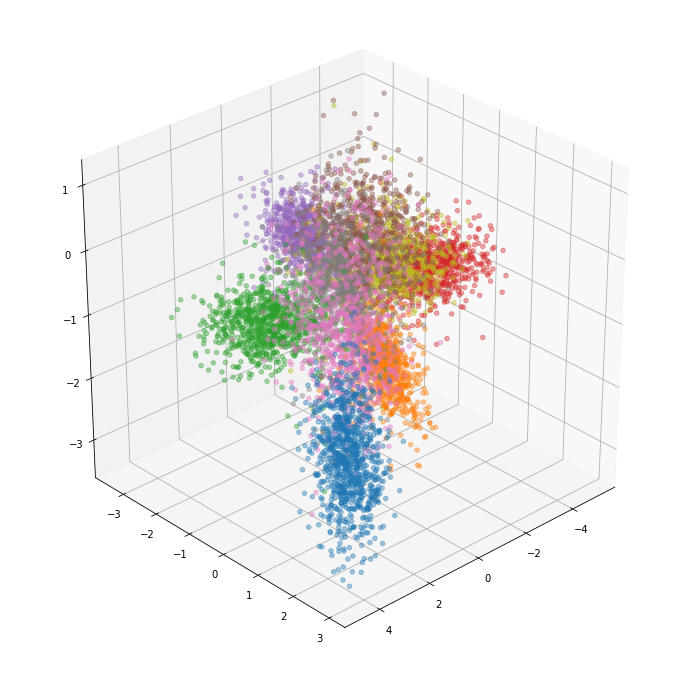

Process Process-1129:
Traceback (most recent call last):
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/mnist.py", line 77, in __getitem__
    img = self.transform(img)
  File "/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/

KeyboardInterrupt: 

In [78]:
from IPython.display import clear_output
from tqdm import tqdm
model.train()
losses_sim = []
losses_dist = []
losses = []
times = []
start = time.time()

for i in tqdm(range(2000)):
    times.append(time.time() - start)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #clusters = gaussian_clusters(output, target)
        clusters = laplacian_clusters(output, target)
        
        #loss_sim = loss_similar_gaussian_mean_div(output, target, clusters)
        loss_sim = loss_similar_laplacian_mean_div(output, target, clusters)
        
        #loss_dist = loss_distinct_gaussian_mean_div(clusters)
        loss_dist = loss_distinct_laplacian_mean_div(clusters, margin=3.)
        
        loss = loss_sim + loss_dist
        loss.backward()
        losses_sim.append(loss_sim.item())
        losses_dist.append(loss_dist.item())
        losses.append(loss.item())
        if batch_idx % 20 == 0:
            clear_output()
            print('Train Epoch: {} {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  i, batch_idx, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item())
                 )
            plot_clusters(output, target)
            
            plt.plot(losses_sim)
            plt.show()
            
            plt.plot(losses_dist)
            plt.show()
            
            plt.plot(losses)
            plt.show()
        
        optimizer.step()

In [79]:
X = []
Y = []

Train Epoch: 0 [0/10000 (0%)]	Loss: 0.799314


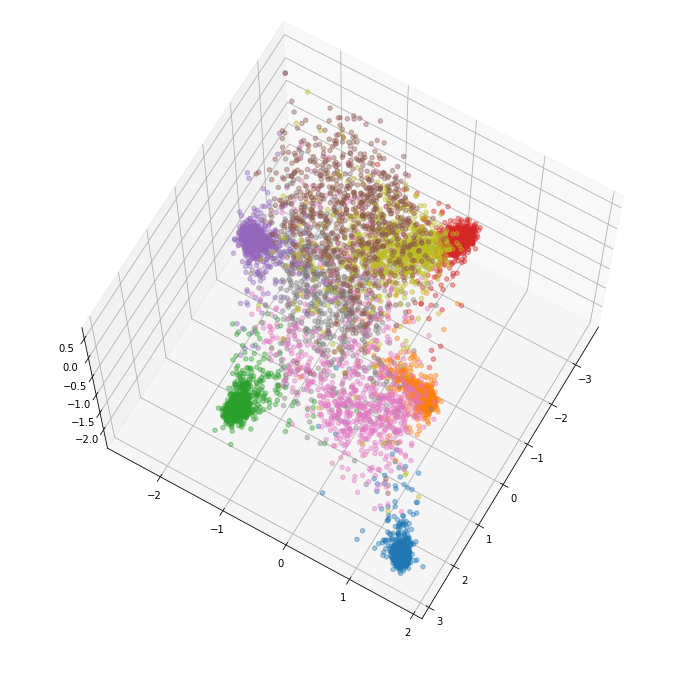

Train Epoch: 1 [1808/10000 (12%)]	Loss: 0.931508


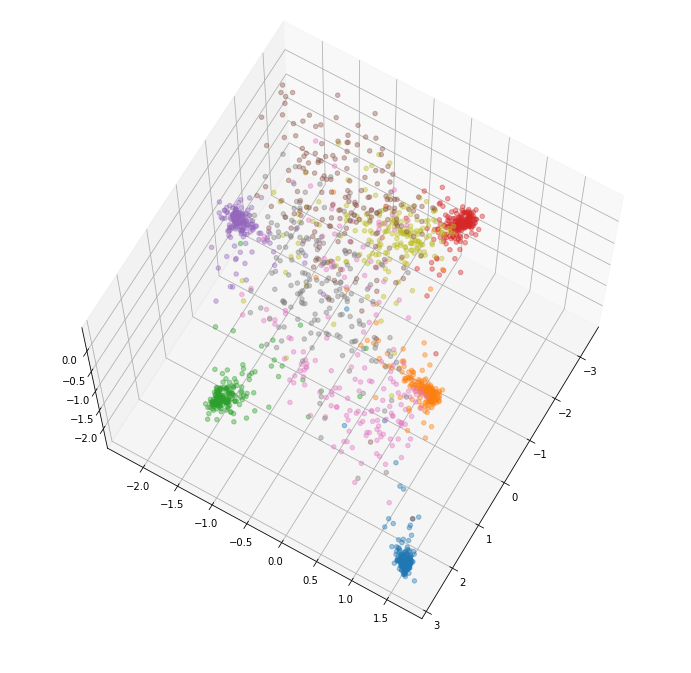

In [80]:
model.train(False)
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    X.append(output[0].cpu().detach().numpy())
    Y.append(target.cpu().detach().numpy())
    clusters = gaussian_clusters(output, target)
    loss = loss_similar_gaussian_mean_div(output, target, clusters) + loss_distinct_gaussian_mean_div(clusters)
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          batch_idx, batch_idx * len(data), len(test_loader.dataset),
100. * batch_idx / len(train_loader), loss.item())
         )
    plot_clusters(output, target, azim=30, elev=70)

In [81]:
X = np.concatenate(X)

In [82]:
Y = np.concatenate(Y)

In [83]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

N = 1000

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, n_iter=8000)
trans_data = tsne.fit_transform(X[:N]).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

t-SNE: 95 sec


In [84]:
tsne.n_iter_

3049

In [85]:
colors = Y[:N]

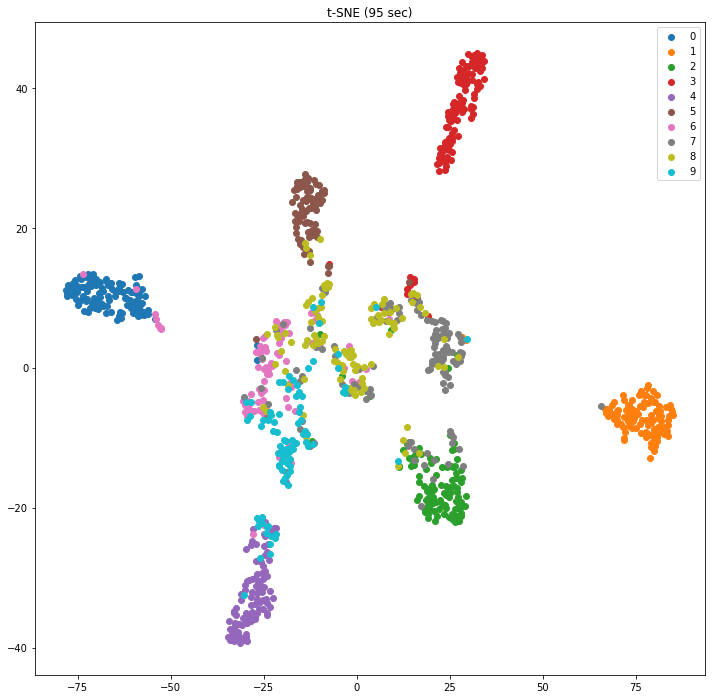

In [86]:
plt.figure(figsize=(12, 12))
for color in np.unique(colors):
    plt.scatter(trans_data[0][colors == color], trans_data[1][colors == color], cmap=plt.cm.rainbow, label=color)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis('tight')
plt.legend()
plt.show()

In [61]:
def plot_clusters_np(nodes_predictions, true_labels, azim=47, elev=30):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

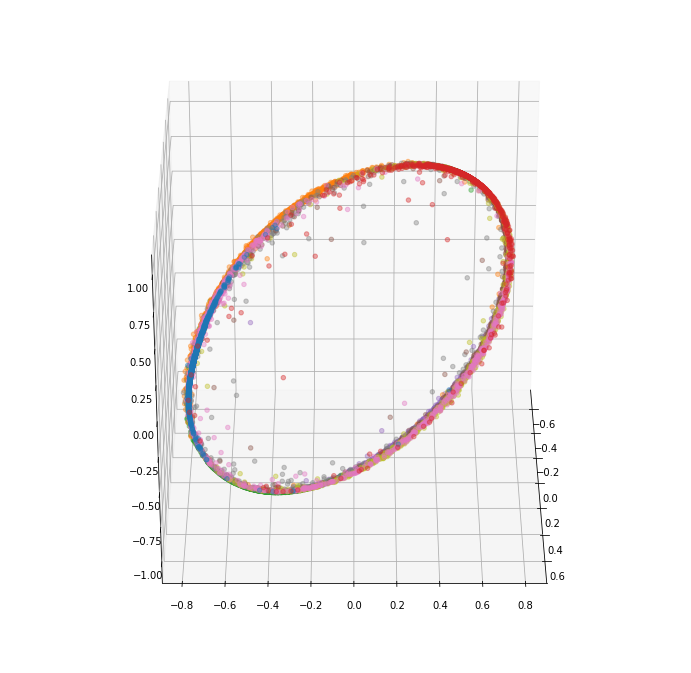

In [62]:
plot_clusters_np(X, Y, azim=0)